# Chicago Airbnb Analysis

## Part 1: Scenario – Chicago Airbnb

You and a group of friends are considering purchasing a property in Chicago that you can use as an investment. You have heard from other people that they have made a lot of money by renting out either a room or an entire unit (apartment or house). Your friends ask you to analyze data so that they can understand how much you would charge per night based on the type of dwelling you were to purchase.


## Part 2 – Split and Store data

In this section, I will load the dataset, split it into training and live data, and store the main dataset in PostgreSQL.

In [41]:
# Importing libraries
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [ ]:
# PostgreSQL connection parameters
host = r'127.0.0.1'  
db = r'MSDS610'      
user = r'postgres'  
pw = r'pdahal001'    
port = r'5432'       
db_conn = create_engine(f"postgresql://{user}:{pw}@{host}:{port}/{db}")

In [3]:
# Loading the csv file
df = pd.read_csv('listings.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6397 entries, 0 to 6396
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6397 non-null   int64  
 1   name                            6397 non-null   object 
 2   host_id                         6397 non-null   int64  
 3   host_name                       6397 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   6397 non-null   object 
 6   latitude                        6397 non-null   float64
 7   longitude                       6397 non-null   float64
 8   room_type                       6397 non-null   object 
 9   price                           6397 non-null   int64  
 10  minimum_nights                  6397 non-null   int64  
 11  number_of_reviews               6397 non-null   int64  
 12  last_review                     52

```
Now i will select a random sample of 100 rows to act as "live data" for later testing:


In [4]:
# Select 100 random rows for live data
live_data = df[['id', 'room_type', 'price', 'number_of_reviews', 'reviews_per_month', 'availability_365']].sample(n=100, random_state=42)
live_data.to_csv("livedata.csv", index=False)

In [5]:
# Remove selected rows from main dataset
df = df.drop(live_data.index)

In [6]:
# save the updated primary DataFrame to a new CSV file
df.to_csv('updateddata.csv', index=False)

In [7]:
# Store remaining data in PostgreSQL
df.to_sql("airbnb_raw", db_conn, schema="raw", if_exists="replace", index=False)

297

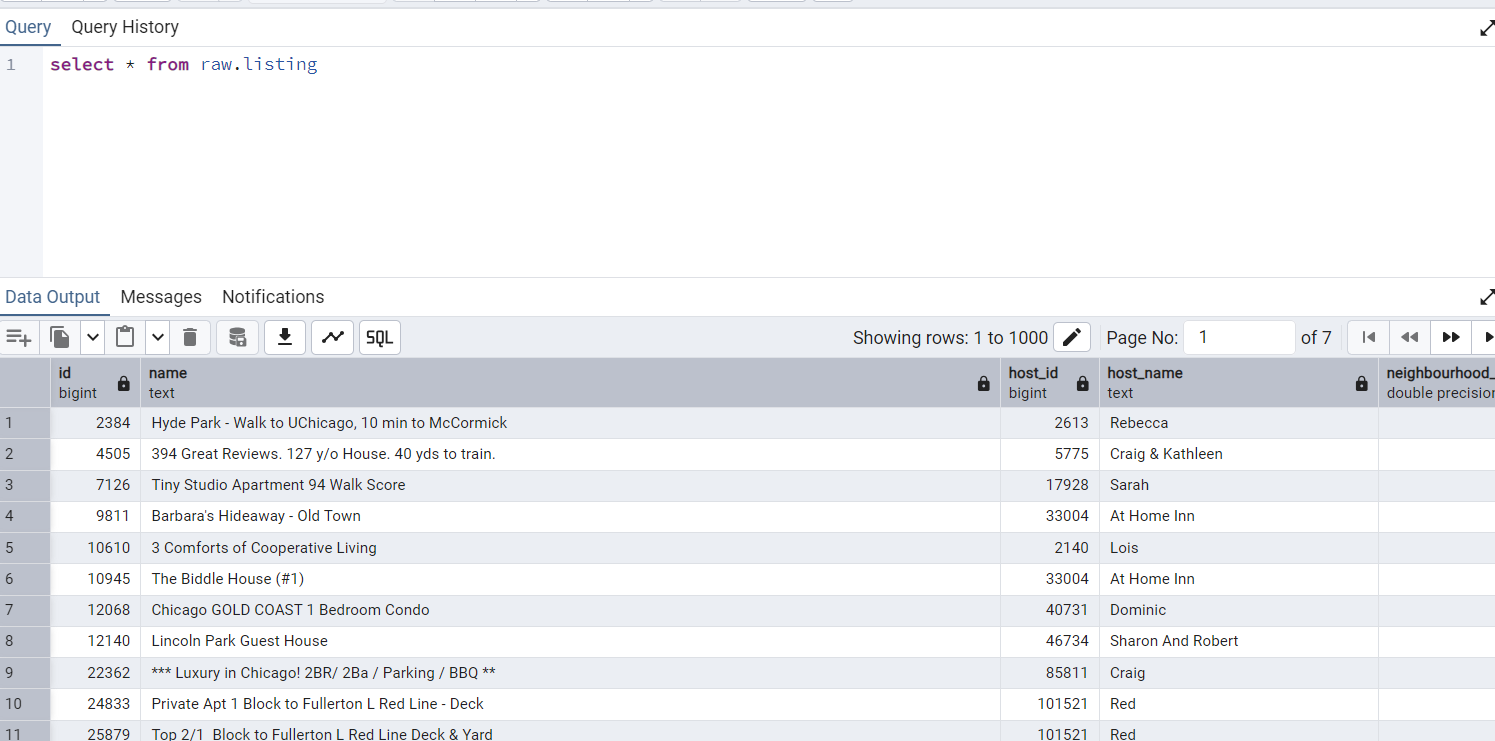

## Part 3 – Data Definition and Analytical Question

### Data Dictionary

After reviewing the dataset, I've identified the following key fields that will be most relevant to analysis:

| Field Name | Description | Data Type |
|------------|-------------|-----------|
| id | Unique identifier for each listing | Discrete (Integer) |
| name | Name/title of the listing | Nominal (Text) |
| host_id | Unique identifier for each host | Discrete (Integer) |
| host_name | Name of the host | Nominal (Text) |
| neighbourhood_group | Grouping of neighborhoods | Nominal (Text) |
| neighbourhood | Specific neighborhood where the property is located | Nominal (Text) |
| latitude | Geographic coordinate - latitude | Continuous (Float) |
| longitude | Geographic coordinate - longitude | Continuous (Float) |
| room_type | Type of room offered (Entire home/apt, Private room, Shared room, Hotel room) | Nominal (Categorical) |
| price | Cost per night in USD | Continuous (Integer) - Our target variable |
| minimum_nights | Minimum number of nights required to book | Discrete (Integer) |
| number_of_reviews | Total number of reviews received | Discrete (Integer) |
| last_review | Date of the last review | Nominal (Date) |
| reviews_per_month | Average number of reviews per month | Continuous (Float) |
| calculated_host_listings_count | Number of listings the host has | Discrete (Integer) |
| availability_365 | Number of days per year the listing is available | Discrete (Integer) |

### Analytical Question

**How can we predict the price per night for an Airbnb listing in Chicago based on property attributes such as room type, review metrics, and availability?**

Target Variable: Price per night (price)

This analysis will help understand what factors influence pricing in the Chicago Airbnb market and allow to estimate potential rental income for different property types and locations.

## Part 4 – Data Prep and Feature Selection

Based on the analytical question, I've decided to focus on a subset of features that I believe will have the strongest influence on the price of an Airbnb listing. The features I've selected are:

- room_type: The type of accommodation directly impacts pricing, with entire homes typically commanding higher prices than private or shared rooms
- number_of_reviews: Properties with more reviews may indicate popularity, which could affect pricing
- reviews_per_month: Activity level and booking frequency can influence price
- availability_365: Properties with higher availability might be priced differently than those with limited availability

I've chosen to exclude several features from the analysis:
- id, host_id: These are unique identifiers and don't provide predictive value for pricing
- name, host_name: Text fields that would require complex NLP techniques beyond the scope of this project
- neighbourhood_group: This column has no data (all values are null)
- latitude/longitude: While location is important, I'll capture this through the neighborhood variable
- last_review: The specific date of the last review is less relevant than the frequency of reviews
- minimum_nights, calculated_host_listings_count: These likely have less direct impact on pricing

In [ ]:
# Display the columns in dataset
print(df.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


In [ ]:
# Drop unnecessary columns and keep only those we need for analysis
df = df[['room_type', 'price', 'number_of_reviews', 'reviews_per_month', 'availability_365']]

In [10]:
# Handle missing values
df.fillna({'reviews_per_month': 0}, inplace=True)

In [11]:
# Convert categorical variables to dummy variables
df = pd.get_dummies(df, columns=['room_type'], drop_first=True)

In [42]:
# Store cleaned data in PostgreSQL
df.to_sql("airbnb_cleaned", db_conn, schema="cleaned", if_exists="replace", index=False)

297

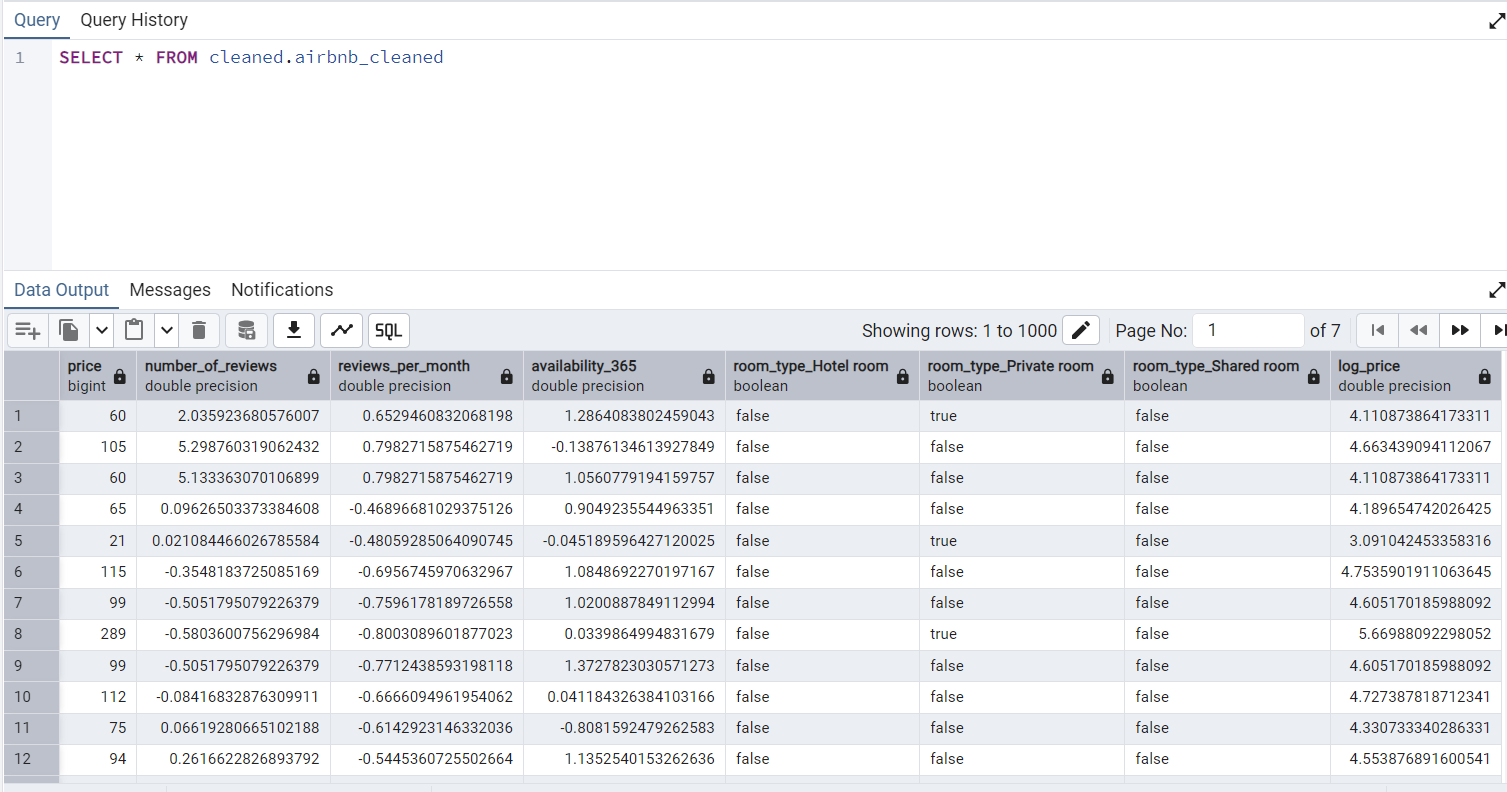

### Data Cleaning Decisions Table

I'll create a reference table in the database that documents our data cleaning decisions:


In [14]:
# Create a table for data cleaning decisions
cleaning_decisions = pd.DataFrame({
    'field_name': ['reviews_per_month', 'room_type', 'price'],
    'manipulation_type': ['fill_na', 'one_hot_encode', 'no_manipulation'],
    'value': ['0', 'drop_first=True', 'None']
})

In [15]:
# Store cleaning decisions in PostgreSQL
cleaning_decisions.to_sql("cleaning_decisions", db_conn, schema="cleaned", if_exists="replace", index=False)

3

In [16]:
# Let's display the cleaning decisions
print(cleaning_decisions)

          field_name manipulation_type            value
0  reviews_per_month           fill_na                0
1          room_type    one_hot_encode  drop_first=True
2              price   no_manipulation             None


## Part 5 – Feature Engineering and Final Prep

For feature engineering, I'll create the following new features to enhance predictive model:

1. log_price: Applying a logarithmic transformation to price will help normalize the distribution, as housing prices often follow a right-skewed distribution
2. Normalization of numerical features: Standardizing the numerical features will help model converge faster and improve performance

These transformations will help model better understand the relationships between features and the target variable.

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
# Feature Engineering: Create new feature - Log price
df['log_price'] = np.log1p(df['price'])

In [19]:
# Normalize numerical features
scaler = StandardScaler()
df[['number_of_reviews', 'reviews_per_month', 'availability_365']] = scaler.fit_transform(
    df[['number_of_reviews', 'reviews_per_month', 'availability_365']]
)

In [20]:
# Save scaler for future use
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [21]:
# Create a table for feature engineering decisions
feature_engineering = pd.DataFrame({
    'field_name': ['price', 'number_of_reviews', 'reviews_per_month', 'availability_365'],
    'transformation_type': ['log_transform', 'standardize', 'standardize', 'standardize'],
    'purpose': ['normalize distribution', 'scale features', 'scale features', 'scale features']
})

In [22]:
# Store feature engineering decisions in PostgreSQL
feature_engineering.to_sql("feature_engineering", db_conn, schema="cleaned", if_exists="replace", index=False)

4

In [23]:
# Store engineered data in PostgreSQL
df.to_sql("airbnb_features", db_conn, schema="cleaned", if_exists="replace", index=False)

297

In [24]:
# Display the feature engineering decisions
print(feature_engineering)

          field_name transformation_type                 purpose
0              price       log_transform  normalize distribution
1  number_of_reviews         standardize          scale features
2  reviews_per_month         standardize          scale features
3   availability_365         standardize          scale features


## Part 6 – Constructing an Optimal Model

For this analysis, I've chosen to use a Random Forest Regressor as my prediction algorithm for several reasons:

1. Random Forests handle non-linear relationships well, which is important for real estate pricing where the relationship between features and price is rarely linear
2. They're robust against overfitting, especially with the limited number of features we're using
3. They can capture complex interactions between features (e.g., how room type and number of reviews might interact to affect price)
4. They don't require feature scaling (though we've done it anyway for best practices)
5. They're relatively easy to interpret compared to other complex models

Now I'll implement the 3-way split method (training, validation, testing) to build and optimize our model:


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [26]:
# Define target variable and features
X = df.drop(columns=['price', 'log_price'])
y = df['log_price']  # We're predicting the log of price

In [27]:
# Split into training, validation, and test sets (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [28]:
# Save these splits for potential use in another notebook
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [29]:
# Train Random Forest model with default parameters
base_model = RandomForestRegressor(random_state=42)
base_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
# Evaluate base model performance
train_pred = base_model.predict(X_train)
val_pred = base_model.predict(X_val)

print("Base Model:")
print("Train RMSE:", mean_squared_error(y_train, train_pred, squared=False))
print("Validation RMSE:", mean_squared_error(y_val, val_pred, squared=False))
print("Train R²:", r2_score(y_train, train_pred))
print("Validation R²:", r2_score(y_val, val_pred))

Base Model:
Train RMSE: 0.3425855109359382
Validation RMSE: 0.6142323604587694
Train R²: 0.7934340056441611
Validation R²: 0.3089764322584859


c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
# Let's tune the model by adjusting n_estimators
n_estimators_list = [50, 100, 200]
best_val_rmse = float('inf')
best_model = None

In [32]:
for n_est in n_estimators_list:
    model = RandomForestRegressor(n_estimators=n_est, random_state=42)
    model.fit(X_train, y_train)
    
    val_pred = model.predict(X_val)
    val_rmse = mean_squared_error(y_val, val_pred, squared=False)
    
    print(f"n_estimators={n_est}, Validation RMSE: {val_rmse}")
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = model

c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


n_estimators=50, Validation RMSE: 0.6170348445442547


c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


n_estimators=100, Validation RMSE: 0.6142323604587694
n_estimators=200, Validation RMSE: 0.6132506524514575


c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [33]:
# Now let's try adjusting max_depth to combat overfitting
max_depth_list = [None, 10, 15, 20]
for depth in max_depth_list:
    model = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    train_rmse = mean_squared_error(y_train, train_pred, squared=False)
    val_rmse = mean_squared_error(y_val, val_pred, squared=False)
    
    print(f"max_depth={depth}, Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}")
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model = model

c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


max_depth=None, Train RMSE: 0.3425855109359382, Validation RMSE: 0.6142323604587694


c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


max_depth=10, Train RMSE: 0.5174557531445488, Validation RMSE: 0.5869010402583352


c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


max_depth=15, Train RMSE: 0.4095823859674415, Validation RMSE: 0.597256912027416
max_depth=20, Train RMSE: 0.3561746498298602, Validation RMSE: 0.6097823348105667


c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Final evaluation on test set
final_model = best_model if best_model is not None else base_model
test_pred = final_model.predict(X_test)
test_rmse = mean_squared_error(y_test, test_pred, squared=False)
test_r2 = r2_score(y_test, test_pred)

print("\nFinal Model Evaluation:")
print("Test RMSE:", test_rmse)
print("Test R²:", test_r2)


Final Model Evaluation:
Test RMSE: 0.6303234640230352
Test R²: 0.3146298449938686


c:\Users\prakr\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [35]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': final_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                  Feature  Importance
4  room_type_Private room    0.388720
1       reviews_per_month    0.216563
2        availability_365    0.186459
0       number_of_reviews    0.113899
5   room_type_Shared room    0.069967
3    room_type_Hotel room    0.024391


In [36]:
# Save final model
joblib.dump(final_model, "airbnb_model.pkl")

['airbnb_model.pkl']

In [37]:
# Save X_train columns order for future reference
pd.Series(X_train.columns).to_csv('X_train_columns.csv', index=False)

# Visualizing the results of our model on the training and validation sets

In [ ]:

# Convert predictions back to original price scale for interpretation
y_train_actual = np.expm1(y_train)
y_val_actual = np.expm1(y_val)
train_pred_actual = np.expm1(train_pred)
val_pred_actual = np.expm1(val_pred)


Text(0, 0.5, 'Predicted Price ($)')

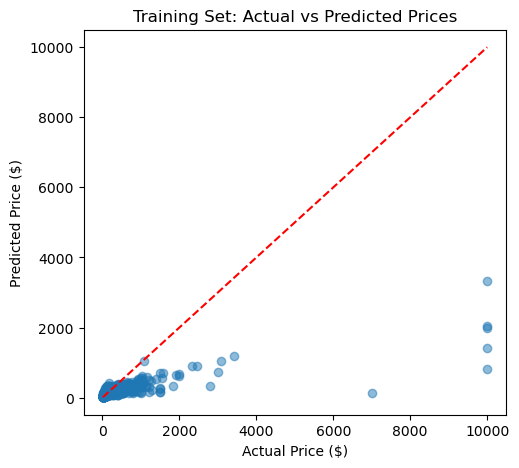

In [39]:
# Plot training set predictions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train_actual, train_pred_actual, alpha=0.5)
plt.plot([min(y_train_actual), max(y_train_actual)], [min(y_train_actual), max(y_train_actual)], 'r--')
plt.title('Training Set: Actual vs Predicted Prices')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')

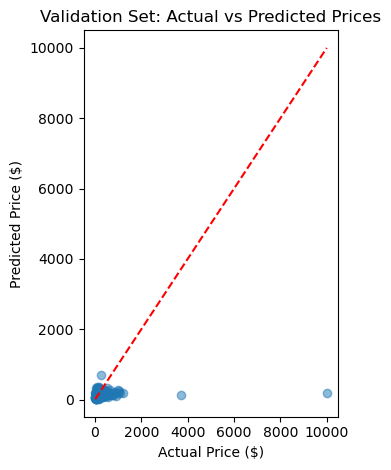

In [40]:
# Plot validation set predictions
plt.subplot(1, 2, 2)
plt.scatter(y_val_actual, val_pred_actual, alpha=0.5)
plt.plot([min(y_val_actual), max(y_val_actual)], [min(y_val_actual), max(y_val_actual)], 'r--')
plt.title('Validation Set: Actual vs Predicted Prices')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')

plt.tight_layout()
plt.show()

I've built this model to predict prices, and this chart shows how my predictions compare to actual prices. Most of my data points are concentrated in the lower price range (under $2,000), where my model performs reasonably well. However, I've noticed my model consistently underpredicts prices for higher-value items you can see this where the blue dots fall below the red diagonal line that represents perfect predictions. The most significant underpredictions occur for items around $10,000, where my model only predicted values between $1,000-$3,500. I'll need to address this issue to improve my model's performance on higher-priced items.